# Predict Time-Series using >1 Features

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Number of periods we will predict ahead
PRED_PERIOD = 800
N_OBS = 10000

In [3]:
# Generate random Data-Frame
input_df = pd.DataFrame({
    'X1':np.sin(np.linspace(0, 300, N_OBS), dtype=np.float32),
    'X2':np.cos(np.linspace(0, 300, N_OBS), dtype=np.float32)
})

In [4]:
# Where, Y will be a non-linear function of both X1 and X2
input_df['Y'] = input_df['X1'] * input_df['X2']**2

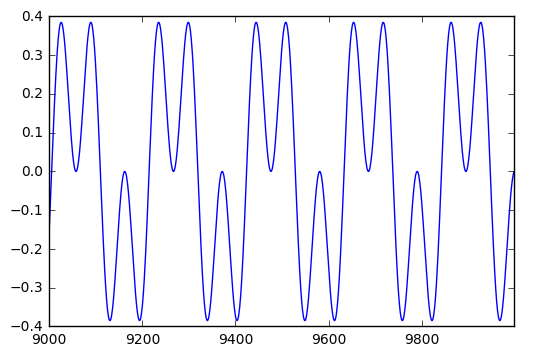

In [5]:
# Example of Y we have created
input_df['Y'][-1000:].plot()

In [6]:
# Split into train and test
dta_train = input_df[:len(input_df)-PRED_PERIOD]
print(len(dta_train))
dta_test = input_df[len(input_df)-PRED_PERIOD:]
print(len(dta_test))

9200
800


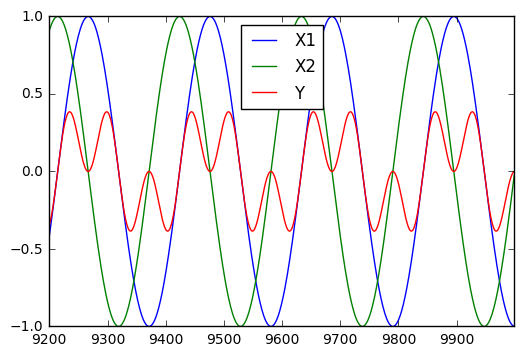

In [7]:
# Time-series we will try to predict
# Y based on previous values of X1 and X2
dta_test.plot()

## 1. Predict Y using both X1 and X2

In [8]:
# Window size for LSTM
SEQ_LEN = 500

In [9]:
def create_seq(dta, seq_len, pred_forward):
    """ Function create sequences from data """
    sequence_length = seq_len + 1
    result = []
    for index in range(len(dta) - sequence_length - pred_forward):
        result.append(dta[index: index + sequence_length + pred_forward])
    result = np.array(result)
    # Ignore last column (y)
    x_train = result[:, :-pred_forward-1, :-1]
    # Use last column (y)
    y_train = result[:, -pred_forward-1:-1, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    return [x_train, y_train]

In [10]:
X_train, y_train = create_seq(dta_train.values, SEQ_LEN, PRED_PERIOD)
# No. of seq, window-size, no. of features
print(X_train.shape)
# No. of seq, pred-period
print(y_train.shape)

(7899, 500, 2)
(7899, 800)


In [11]:
def create_model(layers):
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=False))
    model.add(Dense(units=layers[-1]))
    model.add(Activation("linear"))
    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [12]:
# Build Model (2 inputs, 1 hidden layer(100N), PRED-PERIOD outputs)
model = create_model([X_train.shape[-1], 100, y_train.shape[-1]])

In [13]:
# Train LSTM
model.fit(X_train, y_train, batch_size=500, epochs=10, validation_split=0.1)

Train on 7109 samples, validate on 790 samples
Epoch 1/10
7109/7109 [==============================] - 91s - loss: 0.0536 - val_loss: 0.0371
Epoch 2/10
7109/7109 [==============================] - 46s - loss: 0.0338 - val_loss: 0.0320
Epoch 3/10
7109/7109 [==============================] - 70s - loss: 0.0317 - val_loss: 0.0313
Epoch 4/10
7109/7109 [==============================] - 81s - loss: 0.0311 - val_loss: 0.0306
Epoch 5/10
7109/7109 [==============================] - 56s - loss: 0.0299 - val_loss: 0.0272
Epoch 6/10
7109/7109 [==============================] - 42s - loss: 0.0191 - val_loss: 0.0062
Epoch 7/10
7109/7109 [==============================] - 41s - loss: 0.0033 - val_loss: 0.0012
Epoch 8/10
7109/7109 [==============================] - 42s - loss: 8.9760e-04 - val_loss: 5.6674e-04
Epoch 9/10
7109/7109 [==============================] - 42s - loss: 3.8570e-04 - val_loss: 2.7621e-04
Epoch 10/10
7109/7109 [==============================] - 42s - loss: 2.3119e-04 - val_loss:

In [14]:
# Initialise X on period just before test (-pred_period-seq_len)
X_train_in = input_df[['X1','X2']].values[-PRED_PERIOD-SEQ_LEN:]
X_train_in = X_train_in[:SEQ_LEN]

In [15]:
# Reshape (prefix dim of 1)
X_train_in = X_train_in.reshape(
    1,
    X_train_in.shape[0],
    X_train_in.shape[-1])

In [16]:
# Predict
predicted = model.predict(X_train_in).flatten()

In [17]:
def plot_results(pred, truth):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.plot(truth, label='Truth')
    plt.plot(pred, label='Predictions')
    plt.legend()
    plt.show()

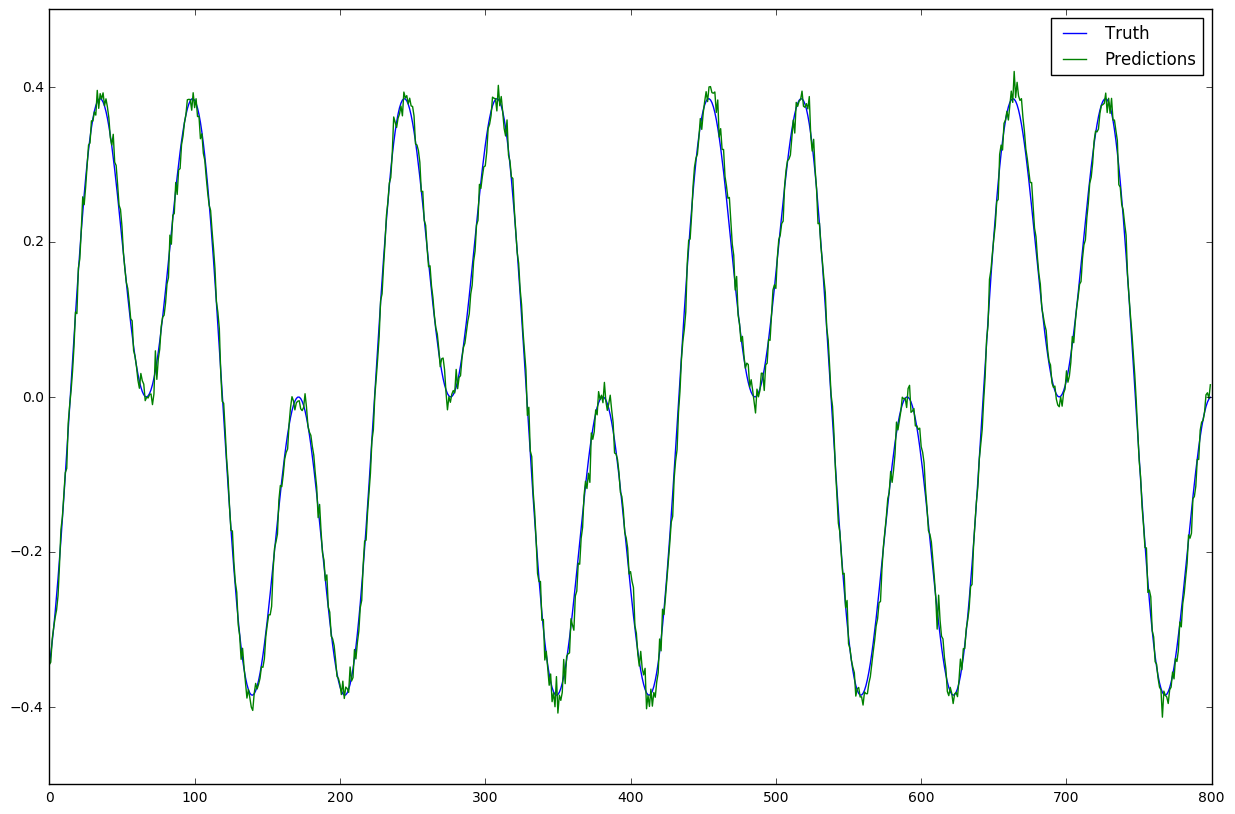

In [18]:
# Visualise
plot_results(predicted, dta_test['Y'].values)